# Solving for  nuclear statistical equilibrium

pynucastro is able to calculate the abundances at nuclear statistical equilibrium of a given reaction network.

The constrained equations are setup following
<cite data-cite-t="calder:2007">Calder et al. (2007)</cite> and
<cite data-cite-t="seitenzahl:2009">Seitenzahl et al. (2009)</cite>
and solved using `scipy.optimize.fsolve()`.

Here we show how to find the NSE state of a set of nuclei.

In [1]:
import pynucastro as pyna
import numpy as np
import matplotlib.pyplot as plt

We start by creating a `Library` object that reads all the ReacLib rates and link different nuclei of choice. 

Then initialize `NSENetwork` by using the the rates created by the `Library` object.

In [2]:
library = pyna.ReacLibLibrary()

subch_full = library.linking_nuclei(["p", "he4",
                                     "c12", "n13", "n14",
                                     "o16", "f18", "ne20",
                                     "ne21", "na22", "na23",
                                     "mg24", "al27", "si28",
                                     "p31", "s32", "cl35",
                                     "ar36", "k39", "ca40",
                                     "sc43", "ti44", "v47",
                                     "cr48", "mn51",
                                     "fe52","co55","ni56"])

nse = pyna.NSENetwork(libraries=subch_full)

`get_comp_nse(rho,T,ye)` is a method of `NSEState` that returns composition at NSE as an object `Composition` by providing density, temperature, and a presribed electron fraction. 

There is pre-set initial guess for the proton and neutron chemical potentials, however one should adjust the initial guess, accordingly if no solutions are found or taking a long time as the algorithm is searching for the correct initial guess. To pass in the initial guess, set `initial_guess=guess`. `guess` is a user-supplied list of the form `[mu_p, mu_n]`, where `mu_p` and `mu_n` are the chemical potential for proton and neutron, respectively.

It has options of incorporating coulomb correction terms by let `use_coulomb_corr=True`, and return the solution of proton and neutron chemical potentials by `return_sol=True`.

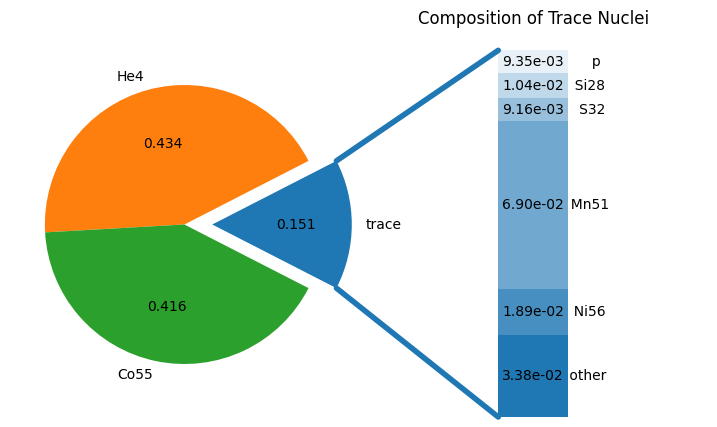

In [3]:
comp, sol = nse.get_comp_nse(1e7, 6e9, 0.50, use_coulomb_corr=True, return_sol=True)
fig = comp.plot()

We can also explicitly print the composition

In [4]:
print(comp)
print(f"After solving, the chemical potential for proton and neutron are {sol[0]} and {sol[1]}")

  X(p) : 0.009350266574298126
  X(He4) : 0.4336426143159986
  X(C12) : 7.728712263230988e-06
  X(N13) : 2.592042273492072e-10
  X(N14) : 1.3663280223921057e-09
  X(O16) : 1.569752257721184e-05
  X(F18) : 2.4113970352901534e-11
  X(Ne20) : 3.0187426124540253e-07
  X(Ne21) : 3.956305618265555e-09
  X(Na22) : 9.687054738180061e-10
  X(Na23) : 7.296885329815052e-08
  X(Mg24) : 3.4701745252768506e-05
  X(Al27) : 3.35262932875393e-05
  X(Si28) : 0.010439577070085705
  X(P31) : 0.0021349882457099433
  X(S32) : 0.009160654967147823
  X(Cl35) : 0.004000867019906003
  X(Ar36) : 0.004879643277695136
  X(K39) : 0.00555270977669994
  X(Ca40) : 0.004769872777955282
  X(Sc43) : 0.0003726841335918931
  X(Ti44) : 0.00022925855334570013
  X(V47) : 0.0049006198947801945
  X(Cr48) : 0.001148869027630562
  X(Mn51) : 0.06904763821666747
  X(Fe52) : 0.005746888495780569
  X(Co55) : 0.4156158836321719
  X(Ni56) : 0.01891492832935047

After solving, the chemical potential for proton and neutron are -7.73860857

For $\rho = 10^7~\mathrm{g~cm^{-3}}$ and electron fraction, $Y_e = 0.5$, we can explore how the NSE state changes with temperature.

Here we used a guess for chemical potential of proton and neutron of -6.0 and -11.5, respectively.

In [5]:
rho = 1e7
ye = 0.5
temps = np.linspace(2.5, 12.0, 100)
X_s = []

guess = [-6.0, -11.5]
for i, temp in enumerate(temps):
    nse_comp, sol = nse.get_comp_nse(rho, temp*1.0e9, ye, init_guess=guess, 
                                     use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s = [nse_comp.X[nuc] for nuc in nse_comp.X]
    X_s.append(nse_X_s)

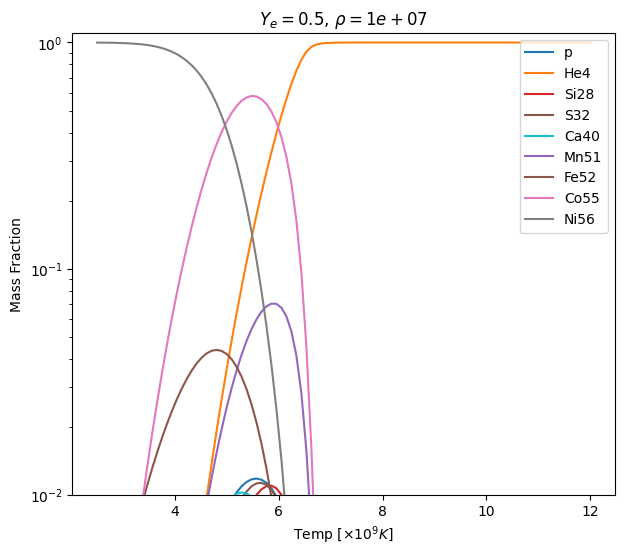

In [6]:
X_s = np.array(X_s)
nuc_names = nse.get_nuclei()

low_limit = 1e-2
fig, ax = plt.subplots()

for k in range(len(nuc_names)):
    line, = ax.plot(temps, X_s[:,k])
    if (max(X_s[:,k]) > low_limit):
        line.set_label(str(nuc_names[k]))

ax.legend(loc = "upper right")
ax.set_xlabel(r'Temp $[\times 10^9 K]$')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([low_limit,1.1])
ax.set_title(rf"$Y_e = {ye}$, $\rho = {rho:6.3g}$")

fig.set_size_inches((7, 6))

For $\rho = 10^7~\mathrm{g~cm^{-3}}$ and a relatively high temperature of $T = 6 \times 10^9~\mathrm{K}$, we can look at how the NSE state changes with varying $Y_e$.

Note: there will be a lowest $Y_e$ that is attainable by the network, depending on what species are represented.  As long as protons are in the network, we can reach a $Y_e$ of $1$.

In [7]:
ye_low = min(nuc.Z/nuc.A for nuc in nse.unique_nuclei)

In [8]:
rho = 1e7
ye_s = np.linspace(ye_low, 0.65, 100)
temp = 6.0e9
X_s_1 = []

guess = [-6.0, -11.5]
for i, ye in enumerate(ye_s):
    nse_comp_1, sol = nse.get_comp_nse(rho, temp, ye, init_guess=guess, 
                                       use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s_1 = [nse_comp_1.X[nuc] for nuc in nse_comp_1.X]
    X_s_1.append(nse_X_s_1)

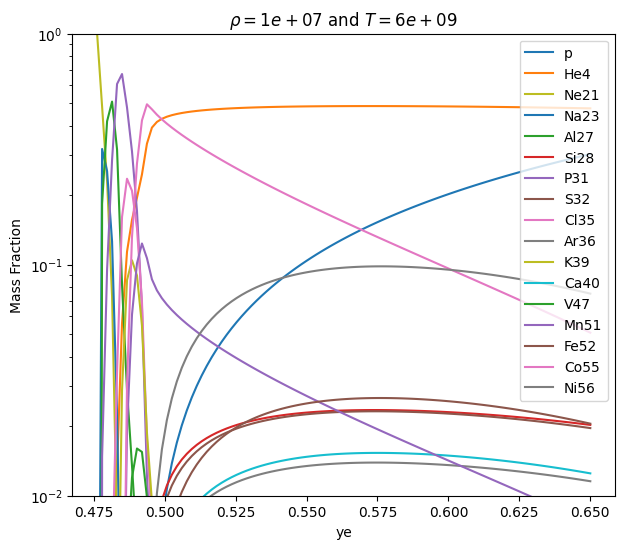

In [9]:
X_s_1 = np.array(X_s_1)
nuc_names = nse.get_nuclei()

fig, ax = plt.subplots()

for k in range(len(nuc_names)):
    line, = ax.plot(ye_s, X_s_1[:,k])
    if (max(X_s_1[:,k]) > 0.01):
        line.set_label(str(nuc_names[k]))

ax.legend(loc="best")
ax.set_xlabel('ye')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([0.01,1])
ax.set_title(rf"$\rho = {rho:6.3g}$ and $T={temp:6.3g}$")

fig.set_size_inches((7, 6))